In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Loads and cleans energy usage data from multiple CSV files in the specified folder path
def load_and_clean_data(folder_path):
    pathlist = Path(folder_path).glob('*.csv')  # Get list of all CSV files in the folder
    comb_data = pd.DataFrame()  # Initialize an empty DataFrame to store combined data

    for path in pathlist:
        try:
            # Read the CSV file
            raw_data = pd.read_csv(str(path))

            # Reset index and rename columns
            reindex_data = raw_data.reset_index()
            reindex_data.columns = ["Account ID", "Service Address", "Day", "Consumption (kWh)", "Temperature(F)"]

            # Drop the first row explicitly using .copy() to avoid chained assignment issues
            data_clean = reindex_data.drop(0, axis=0).copy()

            # Select relevant columns, again using .copy() to avoid warnings
            data_final = data_clean[["Day", "Consumption (kWh)", "Temperature(F)"]].copy()

            # Add the year from the file name and convert to datetime
            year = ' ' + str(path)[-8:-4]
            data_final.loc[:, 'Day'] = pd.to_datetime(data_final['Day'] + year, format='%b %d %Y')

            # Concatenate to the combined DataFrame
            comb_data = pd.concat([comb_data, data_final], ignore_index=True)

        except Exception as e:
            # Print any errors encountered during file processing
            print(f"Error processing {path}: {e}")

    # Sort combined data by date and reset index
    comb_data = comb_data.sort_values(by="Day").reset_index(drop=True)
    return comb_data

In [138]:
def interpolate_data(data, z_thresh=3):
    """
    Cleans the data by handling missing/error values (0, NaN, inf, invalid strings) and removing outliers using Z-score.
    Interpolates missing values and ensures data consistency.
    """
    # Replace 0, inf, -inf with NaN
    data['Temperature(F)'].replace([0, np.inf, -np.inf], pd.NA, inplace=True)
    data['Consumption (kWh)'].replace([0, np.inf, -np.inf], pd.NA, inplace=True)

    # Convert to numeric and coerce invalid values to NaN
    data['Temperature(F)'] = pd.to_numeric(data['Temperature(F)'], errors='coerce')
    data['Consumption (kWh)'] = pd.to_numeric(data['Consumption (kWh)'], errors='coerce')

    # Define Z-score function
    def zscore_outliers(series, threshold):
        mean = series.mean()
        std = series.std()
        z_scores = (series - mean) / std
        return z_scores.abs() > threshold

    # Apply Z-score test to identify and remove outliers
    for col in ['Temperature(F)', 'Consumption (kWh)']:
        series = data[col]
        outliers = zscore_outliers(series, threshold=z_thresh)
        data.loc[outliers, col] = pd.NA  # Mark outliers as NaN

    # Interpolate missing values (including NaNs from outliers)
    for col in ['Temperature(F)', 'Consumption (kWh)']:
        data[col] = data[col].interpolate(method='linear')  # Linear interpolation
        data[col] = data[col].ffill().bfill()  # Fill remaining NaNs using forward and backward fill

    # Ensure numeric conversion for cleaned columns
    data['Temperature(F)'] = pd.to_numeric(data['Temperature(F)'], errors='coerce')
    data['Consumption (kWh)'] = pd.to_numeric(data['Consumption (kWh)'], errors='coerce')

    return data

In [162]:
def plot_data(data):
    """
    Plots daily temperature changes and energy consumption over time.
    Handles any inf or NaN values in the dataset before plotting.
    """
    # Replace any inf or -inf values with NaN and drop rows with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(subset=['Temperature(F)', 'Consumption (kWh)', 'Day'], inplace=True)

    # Plot setup
    fig = plt.figure(figsize=(12, 8), dpi=250)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
    
    # Plot daily temperature changes
    ax1 = fig.add_subplot(gs[0])
    sns.set_style("whitegrid")
    sns.lineplot(x='Day', y='Temperature(F)', data=data, ax=ax1, color='red', linewidth=2, linestyle='--')
    ax1.set_title('Daily Temperature Changes Over Time', fontsize=16)
    ax1.set_ylabel('Temperature (F)', fontsize=12)
    ax1.grid(True, which='major', axis='y', color='gray', linestyle='-', linewidth=0.7)
    ax1.grid(False, which='major', axis='x')
    ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.get_xticklabels(), rotation=45)
    
    # Plot daily energy consumption
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    sns.lineplot(x='Day', y='Consumption (kWh)', data=data, ax=ax2, color='blue', linewidth=2)
    ax2.set_title('Daily Energy Consumption Over Time', fontsize=16)
    ax2.set_ylabel('Energy Consumption (kWh)', fontsize=12)
    ax2.xaxis.set_major_locator(plt.MaxNLocator(15))
    ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax2.get_xticklabels(), rotation=45)
    ax2.grid(True, which='major', axis='y', color='gray', linestyle='-', linewidth=0.7)
    ax2.grid(False, which='major', axis='x')
    
    # Final layout adjustments
    plt.tight_layout()
    plt.show()

In [9]:
def train_and_evaluate_model(data):
    # Ensure 'Day' is in datetime format
    if not np.issubdtype(data['Day'].dtype, np.datetime64):
        data['Day'] = pd.to_datetime(data['Day'], errors='coerce')
        if data['Day'].isna().any():
            raise ValueError("Some dates in 'Day' could not be converted to datetime. Check your data.")

    # Feature Engineering
    data['DayOfWeek'] = data['Day'].dt.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
    data['Month'] = data['Day'].dt.month         # Extract the month
    data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: x >= 5)  # Boolean for weekends

    # Define Features (X) and Target (y)
    X = data[['Temperature(F)', 'DayOfWeek', 'Month', 'IsWeekend']]
    y = data['Consumption (kWh)']

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model Training
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Model Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'R-squared: {r2:.2f}')

    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 6), dpi=250)
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.legend()
    plt.title('Actual vs Predicted Energy Consumption')
    plt.xlabel('Time Index')
    plt.ylabel('Consumption (kWh)')
    plt.grid(True)
    plt.show()

In [11]:
## Import xgboost from library
from xgboost import XGBRegressor

## Trains an XGBoost Regressor model to predict energy consumption and evaluates its performance.
def train_and_evaluate_with_xgboost(data):
    """
    Trains an XGBoost Regressor with hyperparameter tuning using RandomizedSearchCV and evaluates its performance.
    """

    # Ensure 'Day' column is in datetime format
    if not np.issubdtype(data['Day'].dtype, np.datetime64):
        data['Day'] = pd.to_datetime(data['Day'], errors='coerce')  # Convert to datetime
        if data['Day'].isna().any():  # Check for invalid dates
            raise ValueError("Some entries in 'Day' could not be converted to datetime. Check your data.")

    # Day categorization
    data['DayOfWeek'] = data['Day'].dt.dayofweek  # Extract day of the week
    data['Month'] = data['Day'].dt.month  # Extract month
    data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: x >= 5)  # Boolean for weekends
    
    # Defining variables
    X = data[['Temperature(F)', 'DayOfWeek', 'Month', 'IsWeekend']]
    y = data['Consumption (kWh)']
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
    # Parameter grid for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300],  # Number of boosting rounds
        'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
        'max_depth': [3, 5, 7],  # Maximum depth of a tree
        'subsample': [0.7, 0.8, 1.0],  # Fraction of samples used for fitting
        'colsample_bytree': [0.7, 0.8, 1.0]  # Fraction of features used per tree
    }
    
    # Initialize XGBoost Regressor
    model = XGBRegressor(random_state=42)
    
    # Perform Randomized Search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Retrieve the best model from the search
    best_model = random_search.best_estimator_
    print("Best Parameters:", random_search.best_params_)
    
    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)
    
    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'R-squared: {r2:.2f}')
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 6), dpi=250)
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='-')w
    plt.legend()
    plt.title('Actual vs Predicted Energy Consumption (XGBoost)')
    plt.xlabel('Time Index')
    plt.ylabel('Consumption (kWh)')
    plt.grid(True)
    plt.show()

In [154]:
# Main workflow
folder_path = "/Users/haobo2022/Documents/energy-model-black-box/energy usage data"

In [156]:
data = load_and_clean_data(folder_path)

In [158]:
remaining_zeros = data[data['Temperature(F)'] == 0]
print(f"Number of rows where 'Temperature(F)' is 0: {len(remaining_zeros)}")

Number of rows where 'Temperature(F)' is 0: 0


In [150]:
data = interpolate_data(data)

In [152]:
remaining_zeros = data[data['Temperature(F)'] == 0]
print(f"Number of rows where 'Temperature(F)' is 0: {len(remaining_zeros)}")

Number of rows where 'Temperature(F)' is 0: 83


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

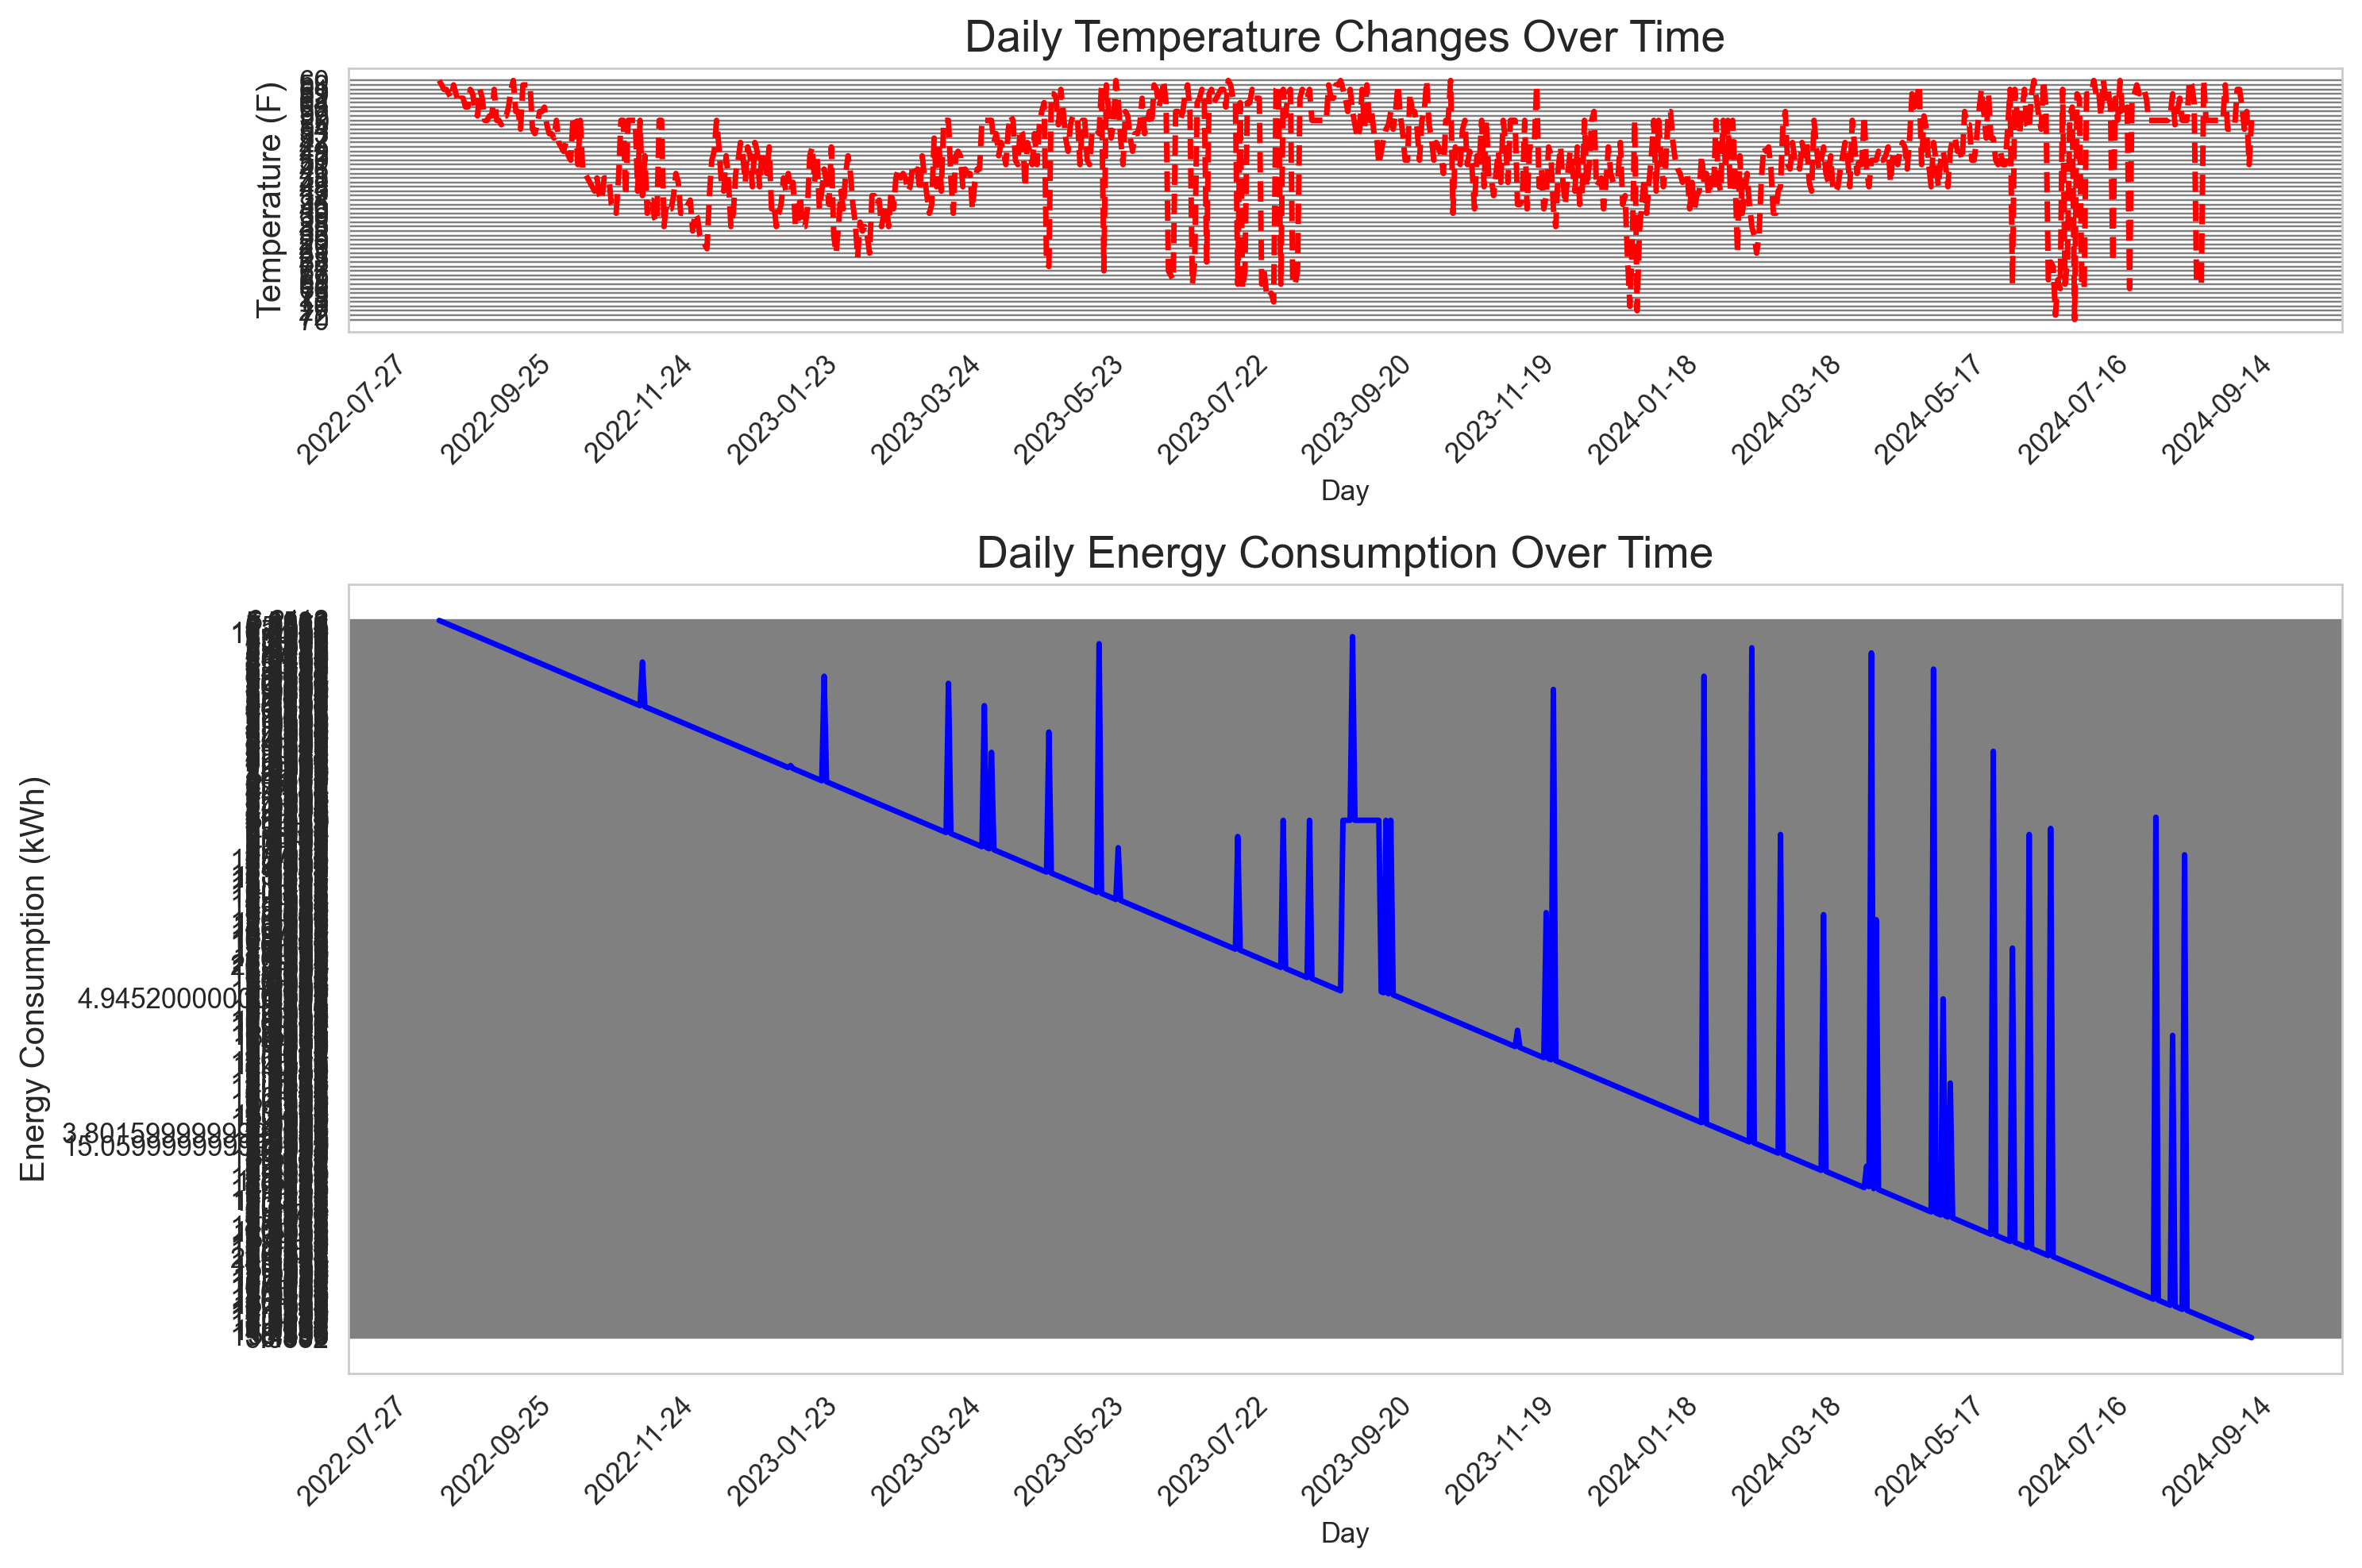

In [160]:
plot_data(data)

Mean Squared Error: 7.61
R-squared: -0.21


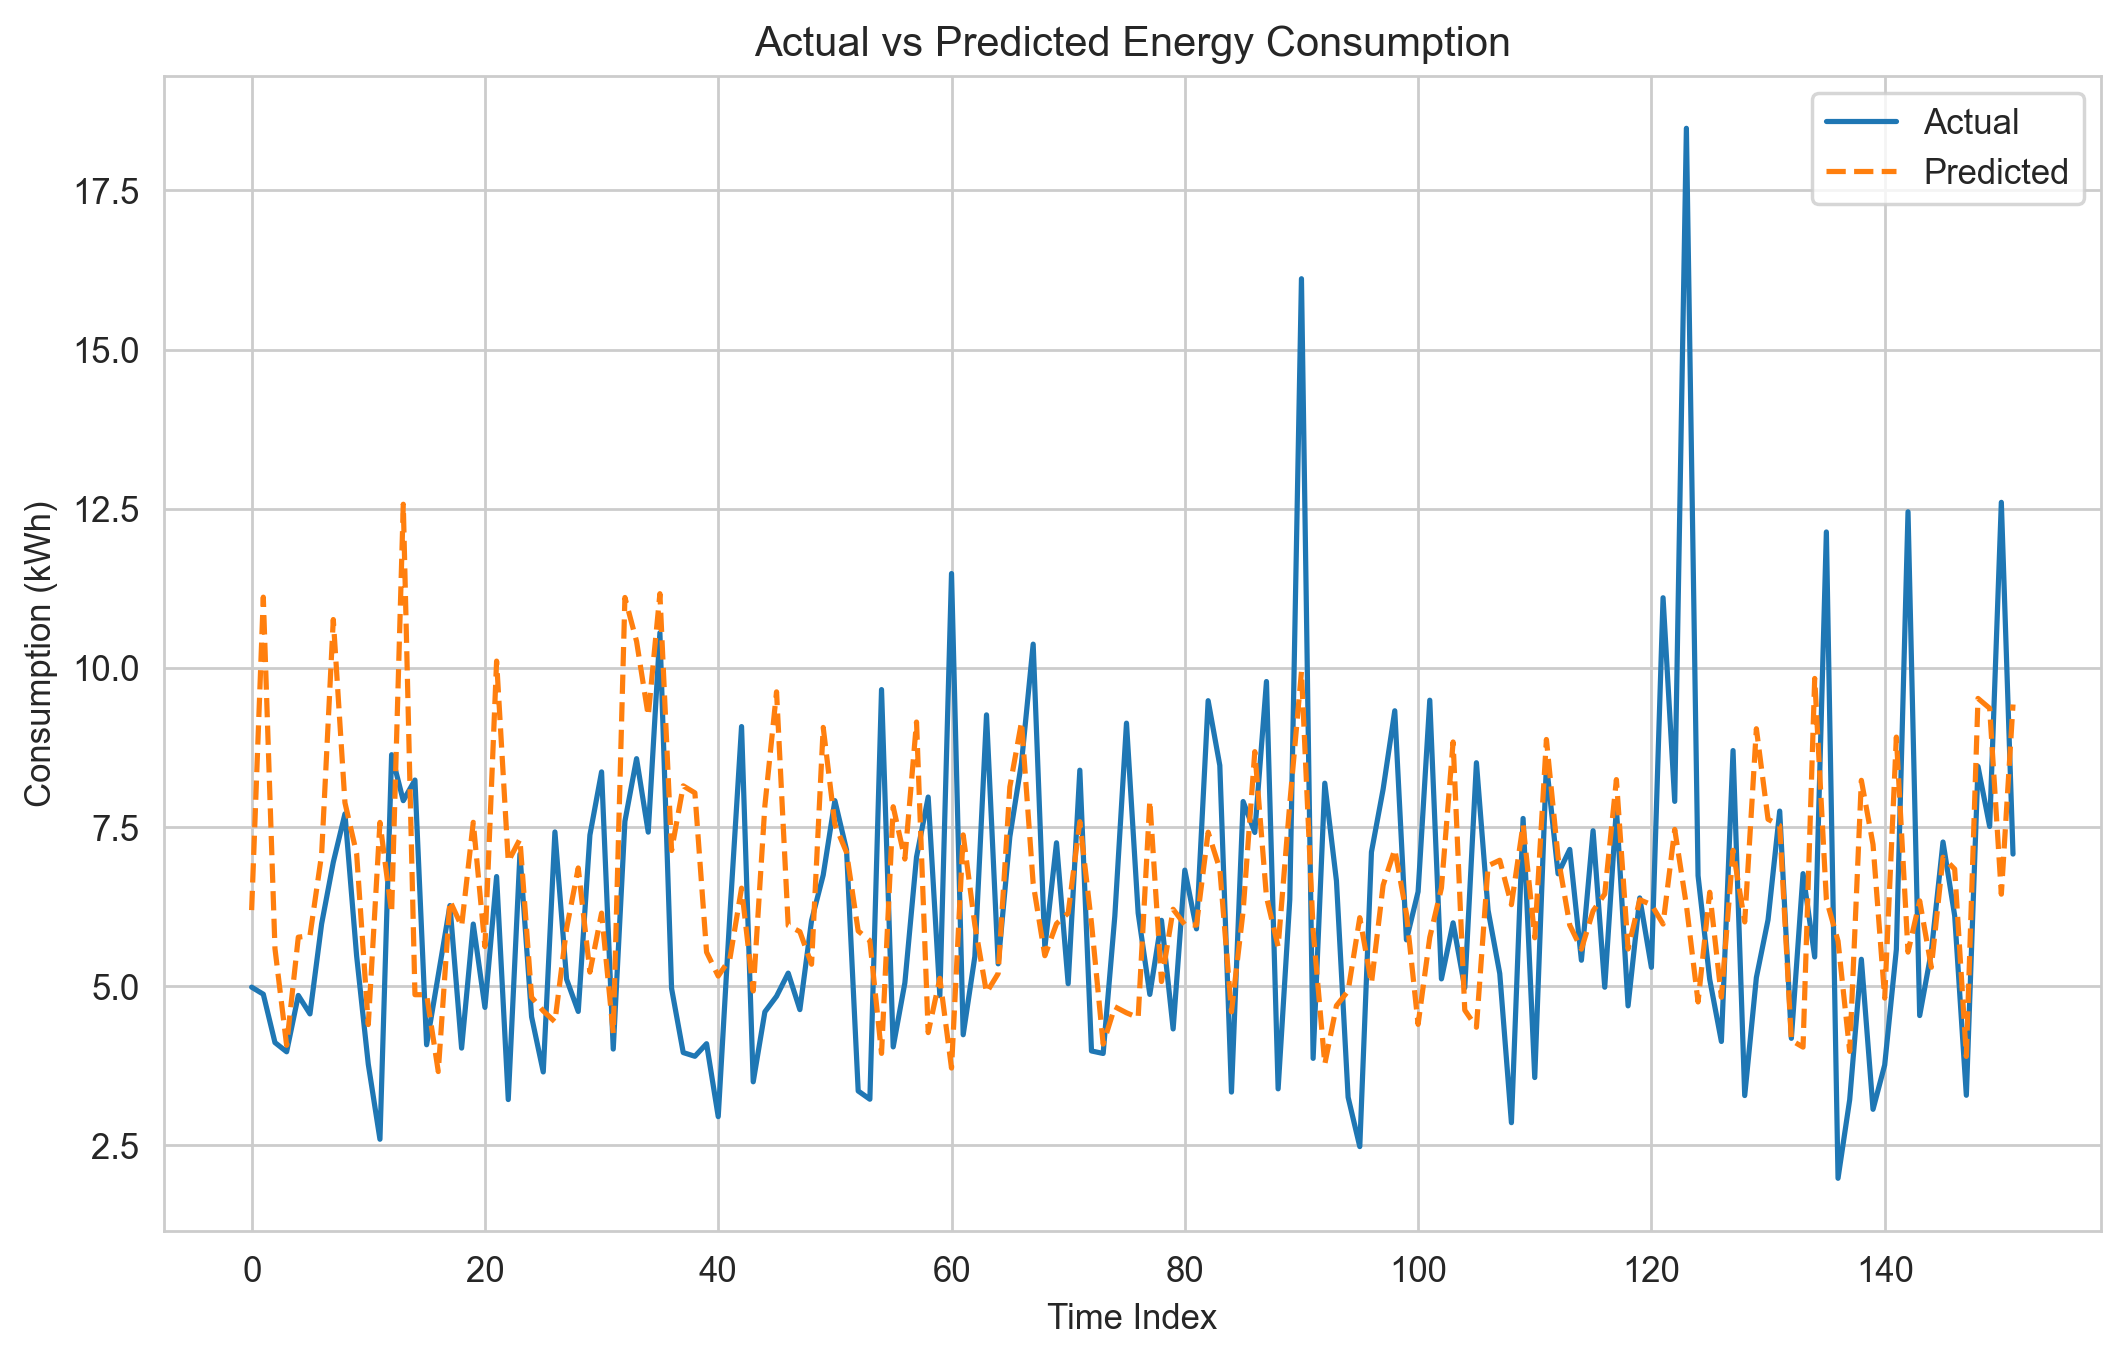

In [75]:
train_and_evaluate_model(data)

In [29]:
train_and_evaluate_with_xgboost(data)

AttributeError: Can only use .dt accessor with datetimelike values